# Sobre o Dataset

O dataset **Chest X-Ray Images (Pneumonia)** contém imagens de radiografias torácicas de pacientes, sendo amplamente utilizado para tarefas de classificação de pneumonia com aprendizado de máquina.

- 📊 **Total de imagens:** 5.863
- 📁 **Divisão em conjuntos:** treino (`train`), validação (`val`) e teste (`test`)
- 🩻 **Classes:**
  - `NORMAL` – pulmões saudáveis
  - `PNEUMONIA` – pulmões com infecção (bacteriana ou viral)
- 🧠 **Objetivo:** treinar modelos de IA para detectar pneumonia com base em exames de raio-X.
- 🔗 **Fonte:** https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## Importação das Bibliotecas

In [1]:
import kagglehub
import os
import shutil
import pandas as pd
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
import matplotlib

sns.set(style='whitegrid') # Define o estilo visual dos gráficos do Seaborn com grade branca de fundo

## 🔍 1.1 Carregamento dos Dados

In [3]:
# 📦 DOWNLOAD DO CONJUNTO DE DADOS DO KAGGLE

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")  # Baixa o dataset de raio-X de pneumonia do Kaggle
print("Path to dataset files:", path)  # Exibe o caminho onde os arquivos foram salvos localmente


Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [4]:
# 📁 CÓPIA DOS DADOS PARA O DIRETÓRIO DE TRABALHO

src_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
dst_dir = '/kaggle/working/chest_xray'

shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)


'/kaggle/working/chest_xray'

In [5]:
# 📌 DEFINIÇÃO DO DIRETÓRIO BASE

base_dir = dst_dir

## 🔍 1.2 Identificação dos Dados

Nesta etapa, realizamos uma série de verificações e transformações para garantir a integridade e a consistência do dataset de imagens. As ações incluíram:

- 🔍 Verificação de imagens corrompidas
- 🎨 Padronização de canais (RGB ou escala de cinza)
- 📐 Redimensionamento para tamanho fixo (ex: 224x224)
- ❌ Remoção de imagens muito pequenas (ex: abaixo de 100x100 px)
- 🧬 Identificação de imagens duplicadas via hash
- ⚫ Verificação de imagens completamente pretas ou brancas
- ⚖️ Verificação da proporção entre as classes
- 📂 Uniformização do formato final das imagens


## 🧹 2. Limpeza e Padronização das Imagens

In [10]:
# 📊 CONTAGEM DE IMAGENS POR CONJUNTO E CLASSE

def contar_imagens(diretorio):
    dados = []
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos: treino, validação e teste
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as classes: NORMAL e PNEUMONIA
            caminho = os.path.join(diretorio, subset, classe)  # Monta o caminho completo da pasta da classe
            # Conta apenas os arquivos com extensão de imagem
            total = len([f for f in os.listdir(caminho) if f.endswith(('jpg', 'jpeg', 'png'))])
            # Armazena os dados em formato de dicionário
            dados.append({'Conjunto': subset, 'Classe': classe, 'Total': total})
    return pd.DataFrame(dados)  # Retorna um DataFrame com as informações

df_contagem = contar_imagens(base_dir)  # Aplica a função ao diretório base
display(df_contagem)  # Exibe a tabela resultante com a contagem de imagens por conjunto e classe


,Conjunto,Classe,Total
0,train,NORMAL,1341
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


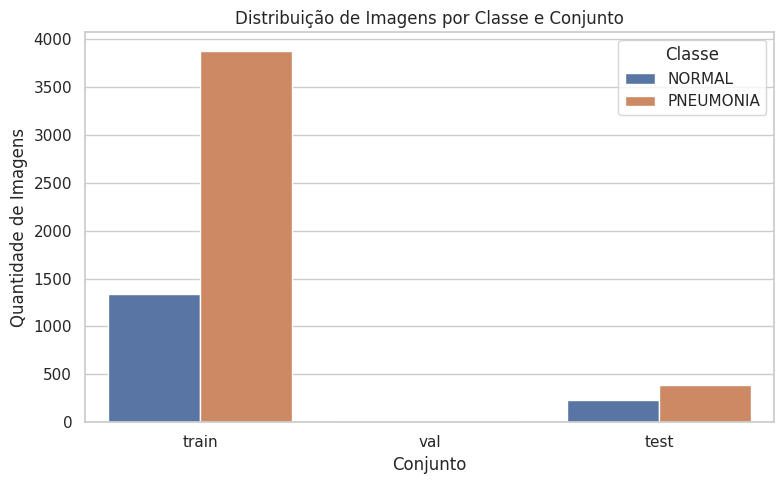

In [11]:
# 📈 VISUALIZAÇÃO DA DISTRIBUIÇÃO DAS IMAGENS

plt.figure(figsize=(8, 5))  # Define o tamanho da figura (largura=8, altura=5)
sns.barplot(data=df_contagem, x='Conjunto', y='Total', hue='Classe')  # Cria um gráfico de barras agrupadas por classe e conjunto
plt.title('Distribuição de Imagens por Classe e Conjunto')  # Título do gráfico
plt.ylabel('Quantidade de Imagens')  # Rótulo do eixo Y
plt.xlabel('Conjunto')  # Rótulo do eixo X
plt.legend(title='Classe')  # Adiciona legenda com título 'Classe'
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()  # Exibe o gráfico


### 2.1 Verificação de formatos e canais

In [12]:
# 🔎 VERIFICAÇÃO DOS FORMATOS DAS IMAGENS

def checar_formatos(diretorio):
    formatos = set()  # Conjunto para armazenar combinações únicas de tamanho e modo de cor das imagens
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos do dataset
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as duas classes
            pasta = os.path.join(diretorio, subset, classe)  # Caminho da pasta da classe
            for arquivo in os.listdir(pasta):  # Itera sobre os arquivos na pasta
                caminho = os.path.join(pasta, arquivo)  # Caminho completo da imagem
                try:
                    img = Image.open(caminho)  # Abre a imagem com PIL
                    formatos.add((img.size, img.mode))  # Adiciona o tamanho e o modo de cor (RGB, L, etc.) ao conjunto
                except:
                    continue  # Ignora arquivos corrompidos ou inválidos
    return formatos  # Retorna o conjunto de formatos únicos encontrados

formatos = checar_formatos(base_dir)  # Aplica a função ao diretório base
print("Formatos únicos encontrados:", formatos)  # Exibe os tamanhos e modos únicos das imagens


Formatos únicos encontrados: {((1690, 1314), 'L'), ((1910, 1661), 'L'), ((1136, 713), 'L'), ((1589, 1044), 'L'), ((2090, 1932), 'L'), ((1336, 1024), 'L'), ((1302, 927), 'L'), ((445, 140), 'RGB'), ((1064, 624), 'L'), ((1056, 544), 'L'), ((1296, 696), 'L'), ((1454, 1071), 'L'), ((1296, 1072), 'L'), ((1434, 1411), 'L'), ((1724, 1476), 'L'), ((1104, 792), 'L'), ((1264, 688), 'L'), ((864, 640), 'L'), ((1168, 880), 'L'), ((1698, 1473), 'L'), ((2172, 1963), 'L'), ((1348, 812), 'L'), ((1824, 1384), 'L'), ((1272, 1040), 'L'), ((1032, 888), 'L'), ((936, 704), 'L'), ((1192, 840), 'L'), ((1144, 848), 'L'), ((1110, 724), 'L'), ((679, 542), 'RGB'), ((1372, 948), 'L'), ((1654, 1313), 'L'), ((1456, 896), 'L'), ((1008, 800), 'L'), ((1704, 1544), 'L'), ((1168, 808), 'L'), ((1024, 696), 'L'), ((1554, 1345), 'L'), ((832, 416), 'L'), ((1638, 1323), 'L'), ((1368, 872), 'L'), ((1032, 536), 'L'), ((1096, 472), 'L'), ((904, 568), 'L'), ((1000, 664), 'L'), ((1256, 856), 'L'), ((1786, 1449), 'L'), ((760, 512), '

### 2.2 Função de limpeza (conversão, remoção, hashing)

In [13]:
def imagem_pequena(img, min_size=(100, 100)):
    return img.size[0] < min_size[0] or img.size[1] < min_size[1]

In [14]:
def imagem_duplicada(img, hash_set):
    hash_val = hashlib.md5(img.tobytes()).hexdigest()
    if hash_val in hash_set:
        return True
    hash_set.add(hash_val)
    return False

In [15]:
def converter_para_cinza(img):
    if USE_GRAYSCALE:
        return img.convert('L')
    else:
        return img.convert('RGB')

In [16]:
def limpar_e_padronizar_imagens(base_dir):
    hash_set = set()
    total_removidas = 0
    total_convertidas = 0

    print("🧼 Iniciando limpeza e conversão das imagens...")

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                print(f"⚠️ Pasta não encontrada: {path}")
                continue

            files = os.listdir(path)
            print(f"\n📂 Processando {subset}/{classe} – {len(files)} arquivos")

            for file in files:
                file_path = os.path.join(path, file)

                try:
                    img = Image.open(file_path)

                    if imagem_pequena(img):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"🗑️ Removida (pequena): {file}")
                        continue

                    img = converter_para_cinza(img)

                    if imagem_duplicada(img, hash_set):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"🗑️ Removida (duplicada): {file}")
                        continue

                    img.save(file_path)
                    total_convertidas += 1
                    print(f"✅ Convertida para escala de cinza: {file}")

                except Exception as e:
                    os.remove(file_path)
                    total_removidas += 1
                    print(f"❌ Erro ao processar {file}: {e}")

    print("\n📊 Etapa de limpeza finalizada!")
    print(f"🗑️ Total de imagens removidas: {total_removidas}")
    print(f"✅ Total convertidas e salvas: {total_convertidas}")

    # 🔧 Aplica o redimensionamento final após limpeza
    print("\n📐 Iniciando redimensionamento para tamanho padrão...")


In [17]:
def redimensionar_imagens(base_dir, target_size=(128, 128)):
    total_redimensionadas = 0
    erros = 0

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                continue

            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                try:
                    img = Image.open(file_path)
                    img = img.resize(target_size)
                    img.save(file_path)
                    total_redimensionadas += 1
                except Exception as e:
                    erros += 1
                    print(f"❌ Erro ao redimensionar {file}: {e}")

    print(f"✅ Total redimensionadas: {total_redimensionadas}")
    print(f"❌ Erros: {erros}")


In [18]:
redimensionar_imagens(base_dir, target_size=(128, 128))

✅ Total redimensionadas: 5856
❌ Erros: 0


## 📊 3. Análise Exploratória dos Dados

In [19]:
# ✅ VERIFICAÇÃO FINAL DO FORMATO DAS IMAGENS PADRONIZADAS

def checar_formato_final(base_dir):
    formatos = set()  # Conjunto para armazenar os formatos únicos encontrados
    for subset in ['train', 'val', 'test']:  # Itera sobre os subconjuntos
        for classe in ['NORMAL', 'PNEUMONIA']:  # Itera sobre as classes
            path = os.path.join(base_dir, subset, classe)  # Caminho da pasta da classe
            for file in os.listdir(path):  # Itera sobre os arquivos da pasta
                img = Image.open(os.path.join(path, file))  # Abre a imagem
                formatos.add((img.size, img.mode))  # Adiciona o tamanho e modo (ex: (128, 128), 'L') ao conjunto
    return formatos  # Retorna os formatos únicos encontrados

print(checar_formato_final(dst_dir))  # Exibe os formatos finais encontrados após a limpeza


{((128, 128), 'RGB'), ((128, 128), 'L')}


In [20]:
import os

def listar_amostras(diretorio):
    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            pasta = os.path.join(diretorio, subset, classe)
            if os.path.exists(pasta):
                arquivos = os.listdir(pasta)
                print(f"📂 {subset}/{classe} → {len(arquivos)} arquivos")
                print("Exemplos:", arquivos[:3])
            else:
                print(f"❌ Pasta não encontrada: {pasta}")

listar_amostras(dst_dir)


📂 train/NORMAL → 1341 arquivos
Exemplos: ['NORMAL2-IM-0678-0001.jpeg', 'NORMAL2-IM-1260-0001.jpeg', 'NORMAL2-IM-0869-0001.jpeg']
📂 train/PNEUMONIA → 3875 arquivos
Exemplos: ['person1392_bacteria_3538.jpeg', 'person579_bacteria_2382.jpeg', 'person1469_virus_2547.jpeg']
📂 val/NORMAL → 8 arquivos
Exemplos: ['NORMAL2-IM-1440-0001.jpeg', 'NORMAL2-IM-1431-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg']
📂 val/PNEUMONIA → 8 arquivos
Exemplos: ['person1946_bacteria_4874.jpeg', 'person1949_bacteria_4880.jpeg', 'person1954_bacteria_4886.jpeg']
📂 test/NORMAL → 234 arquivos
Exemplos: ['NORMAL2-IM-0330-0001.jpeg', 'NORMAL2-IM-0249-0001.jpeg', 'NORMAL2-IM-0229-0001.jpeg']
📂 test/PNEUMONIA → 390 arquivos
Exemplos: ['person86_bacteria_428.jpeg', 'person110_bacteria_531.jpeg', 'person1645_virus_2845.jpeg']


In [21]:
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

'/kaggle/working/chest_xray'

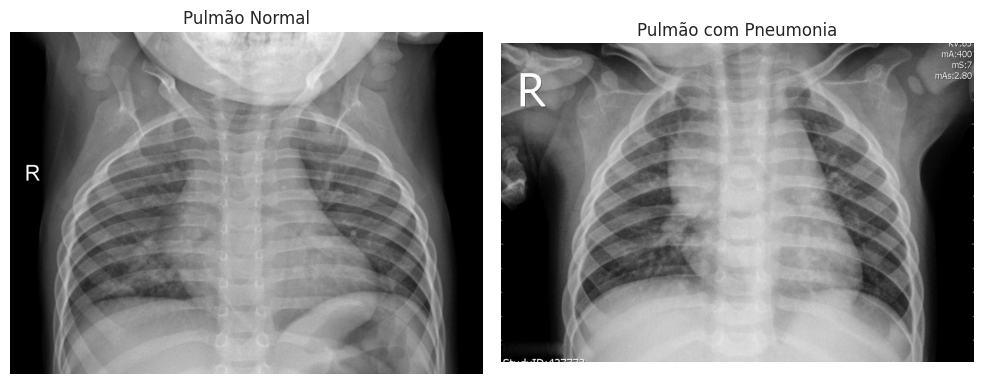

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Caminhos das amostras
caminho_normal = os.path.join(dst_dir, 'train', 'NORMAL')
caminho_pneumonia = os.path.join(dst_dir, 'train', 'PNEUMONIA')

# Pega o primeiro arquivo de cada classe
arquivo_normal = os.listdir(caminho_normal)[0]
arquivo_pneumonia = os.listdir(caminho_pneumonia)[0]

# Abre as imagens
img_normal = Image.open(os.path.join(caminho_normal, arquivo_normal))
img_pneumonia = Image.open(os.path.join(caminho_pneumonia, arquivo_pneumonia))

# Plota lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_normal, cmap='gray')
axes[0].set_title("Pulmão Normal")
axes[0].axis('off')

axes[1].imshow(img_pneumonia, cmap='gray')
axes[1].set_title("Pulmão com Pneumonia")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import os

for subset in ['train']:
    for classe in ['NORMAL', 'PNEUMONIA']:
        pasta = os.path.join(dst_dir, subset, classe)
        print(f"📂 Classe {classe} – Total de arquivos:", len(os.listdir(pasta)))

📂 Classe NORMAL – Total de arquivos: 1341
📂 Classe PNEUMONIA – Total de arquivos: 3875


## 🧪 4. Pré-processamento para CNN

In [ ]:
from tensorflow.keras.utils import img_to_array
from PIL import Image
import numpy as np
import os

def carregar_imagens_e_rotulos(diretorio_base, subset):
    imagens = []
    rotulos = []
    classes = ['NORMAL', 'PNEUMONIA']

    for classe_idx, classe_nome in enumerate(classes):
        pasta = os.path.join(diretorio_base, subset, classe_nome)
        for nome_arquivo in os.listdir(pasta):
            caminho = os.path.join(pasta, nome_arquivo)
            try:
                img = Image.open(caminho)  # já está em grayscale e redimensionada
                img_array = img_to_array(img)
                imagens.append(img_array)
                rotulos.append(classe_idx)
            except:
                continue
    return np.array(imagens), np.array(rotulos)

X_treinamento, y_treinamento = carregar_imagens_e_rotulos(dst_dir, 'train')
X_teste, y_teste = carregar_imagens_e_rotulos(dst_dir, 'test')

print("✅ Dados carregados:")
print("X_treinamento:", X_treinamento.shape)
print("X_teste:", X_teste.shape)


In [ ]:
# 🧪 PRÉ-PROCESSAMENTO DOS DADOS DE ENTRADA

# Mostra as dimensões dos conjuntos de treino e teste antes da transformação
print(f"🔍 Antes da normalização – treino: {X_treinamento.shape}, teste: {X_teste.shape}")

# 🔄 Converte os valores dos pixels para float e normaliza para o intervalo [0, 1]
X_treinamento = X_treinamento.astype('float32') / 255
X_teste = X_teste.astype('float32') / 255

# Mostra as novas dimensões dos dados após a normalização
print(f"✅ Depois da normalização – treino: {X_treinamento.shape}, teste: {X_teste.shape}\n")

🔍 Antes da normalização – treino: (5216, 128, 128, 1), teste: (624, 128, 128, 1)
✅ Depois da normalização – treino: (5216, 128, 128, 1), teste: (624, 128, 128, 1)



## 🧠 5. Construção da CNN Customizada

In [ ]:
# 🧠 CONFIGURAÇÃO E DEFINIÇÃO DA ARQUITETURA DA CNN

# --- Configuração de Hiperparâmetros da Arquitetura ---
NUM_FILTERS  = 32          # Quantidade de filtros na camada convolucional
KERNEL_SIZE  = (3, 3)      # Tamanho do kernel (janela) da convolução
POOL_SIZE    = (2, 2)      # Tamanho do kernel de pooling (redução espacial)
DENSE_UNITS  = 128         # Número de neurônios na camada densa intermediária
DROPOUT_RATE = 0.2         # Taxa de dropout (20%) para evitar overfitting

# --- Importação dos componentes da rede ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Definição da Arquitetura da CNN ---
rede = Sequential([  # Rede sequencial (feedforward)
    InputLayer(input_shape=(128, 128, 1)),                  # Camada de entrada para imagens 28x28 com 1 canal
    Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'), # Camada convolucional com ReLU
    BatchNormalization(),                                # Normalização dos dados para melhorar estabilidade
    MaxPooling2D(pool_size=POOL_SIZE),                   # Pooling para redução de dimensionalidade
    Flatten(),                                           # Achata o mapa de ativação em um vetor 1D
    Dense(DENSE_UNITS, activation='relu'),               # Camada totalmente conectada com ReLU
    Dropout(DROPOUT_RATE),                               # Dropout para prevenir overfitting
    Dense(len(nomes_classes), activation='softmax')      # Camada de saída com softmax para classificação multiclasse
])

# 📋 Exibe o resumo da arquitetura da rede (camadas, parâmetros, forma dos dados)
rede.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257,858 (62.02 MB)

 Trainable params: 16,257,794 (62.02 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# 🧾 VERIFICAÇÃO DAS DIMENSÕES DOS DADOS DE TREINAMENTO

print(X_treinamento.shape)  # Exibe a forma do conjunto de imagens de treino (esperado: (n_amostras, 28, 28, 1))
print(y_treinamento.shape)  # Exibe a forma do vetor de rótulos (esperado: (n_amostras,))

(5216, 128, 128, 1)
(5216,)


In [ ]:
# ✅ VERIFICAÇÃO DE VALORES NULOS (NaN) NOS DADOS

import numpy as np

print(np.isnan(X_treinamento).sum())  # Verifica se há valores NaN nas imagens de treino (deve retornar 0)
print(np.isnan(y_treinamento).sum())  # Verifica se há valores NaN nos rótulos de treino (deve retornar 0)


0
0


In [ ]:
# 🔍 VERIFICAÇÃO DOS TIPOS DE DADOS (dtype)

print(X_treinamento.dtype)  # Mostra o tipo de dados das imagens (esperado: float32 após normalização)
print(y_treinamento.dtype)  # Mostra o tipo de dados dos rótulos (esperado: int32 ou int64 para classificação)


float32
int64


In [ ]:
# 🧪 CONVERSÃO DOS TIPOS DE DADOS

X_treinamento = X_treinamento.astype('float32')  # Garante que as imagens estejam no formato float32 (necessário para o TensorFlow)
y_treinamento = y_treinamento.astype('int32')    # Garante que os rótulos estejam como inteiros (int32), exigido por algumas funções de perda
# 🔁 VERIFICAÇÃO FINAL DOS TIPOS DE DADOS APÓS CONVERSÃO

print(X_treinamento.dtype)  # Deve exibir: float32
print(y_treinamento.dtype)  # Deve exibir: int32



float32
int32


In [ ]:
# 📐 VERIFICAÇÃO DO FORMATO DAS IMAGENS (PARA REDES SEQUENCIAIS OU CONVOLUCIONAIS)

print(X_treinamento.shape)  # Exibe o shape atual — deve ser algo como (N, 28, 28, 1) para CNNs


(5216, 128, 128, 1)


In [ ]:
# 🧱 ACHATAMENTO DAS IMAGENS PARA USO EM REDE DENSAMENTE CONECTADA (MLP)

X_treinamento_flat = X_treinamento.reshape((X_treinamento.shape[0], -1))  # Achata cada imagem 28x28 em um vetor de 784 elementos

print(X_treinamento_flat.shape)  # Exibe a nova forma: (n_amostras, 784) — exemplo: (60000, 784)


(5216, 16384)


In [ ]:
# 🔎 FILTRAGEM DOS DADOS PARA CLASSIFICAÇÃO BINÁRIA (NORMAL vs PNEUMONIA)

# Apenas para garantir que os rótulos estejam no formato certo
y_treinamento = y_treinamento.astype('int32')

# Cria uma máscara booleana para selecionar apenas as amostras com rótulos 0 ou 1
mascara_binaria = (y_treinamento == 0) | (y_treinamento == 1)

# Aplica a máscara nos dados de treino
X_treinamento_bin = X_treinamento[mascara_binaria]
y_treinamento_bin = y_treinamento[mascara_binaria]

# Verifica se tudo está certo
print("X_treinamento_bin:", X_treinamento_bin.shape)
print("y_treinamento_bin:", y_treinamento_bin.shape)


X_treinamento_bin: (5216, 128, 128, 1)
y_treinamento_bin: (5216,)


## 🚀 6. Treinamento com EarlyStopping

In [ ]:
# 🧠 TREINAMENTO DO MODELO COM VALIDAÇÃO E EARLY STOPPING

from tensorflow.keras.callbacks import EarlyStopping  # Importa o callback para interromper o treino quando a validação parar de melhorar

# --- Configuração dos Hiperparâmetros de Treinamento ---
BATCH_SIZE        = 128        # Quantidade de amostras processadas antes de atualizar os pesos
EPOCHS            = 15         # Número máximo de épocas (ciclos completos pelo conjunto de treino)
PATIENCE          = 3          # Número de épocas sem melhoria para ativar o EarlyStopping
VALIDATION_SPLIT  = 0.2        # Percentual dos dados de treino reservado para validação
OPTIMIZER         = 'adam'     # Algoritmo de otimização (Adam é eficiente e amplamente usado)

# 🛠️ Compila o modelo com função de perda e métrica
rede.compile(loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse com rótulos inteiros
             optimizer=OPTIMIZER,                     # Otimizador definido acima (Adam)
             metrics=['accuracy'])                    # Métrica de desempenho: acurácia

# ⏹️ Configuração do EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitora a perda na validação
    patience=PATIENCE,              # Número de épocas sem melhora antes de parar
    restore_best_weights=True       # Recupera os melhores pesos observados durante o treino
)

# 🚀 Inicia o treinamento do modelo com os dados filtrados para classificação binária
treinamento = rede.fit(
    X_treinamento_bin, y_treinamento_bin,             # Dados de entrada e rótulos
    batch_size=BATCH_SIZE,                            # Tamanho do lote
    epochs=EPOCHS,                                     # Número máximo de épocas
    validation_split=VALIDATION_SPLIT,                # Porcentagem dos dados usada para validação
    callbacks=[early_stopping]                        # Aplica o EarlyStopping durante o treino
)


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.6312 - loss: 5.9091 - val_accuracy: 0.9981 - val_loss: 0.2279
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8711 - loss: 0.2436 - val_accuracy: 0.9933 - val_loss: 0.2494
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9548 - loss: 0.1302 - val_accuracy: 0.9962 - val_loss: 0.2003
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.9648 - loss: 0.1032 - val_accuracy: 0.9971 - val_loss: 0.2015
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.9753 - loss: 0.0714 - val_accuracy: 0.9971 - val_loss: 0.1261
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9799 - loss: 0.0525 - val_accuracy: 0.9952 - val_loss: 0.1029
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9849 - loss: 0.0404 - val_accuracy: 0.9990 - val_loss: 0.0533
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9878 - loss: 0.0329 - val_accuracy: 0.9875 - v

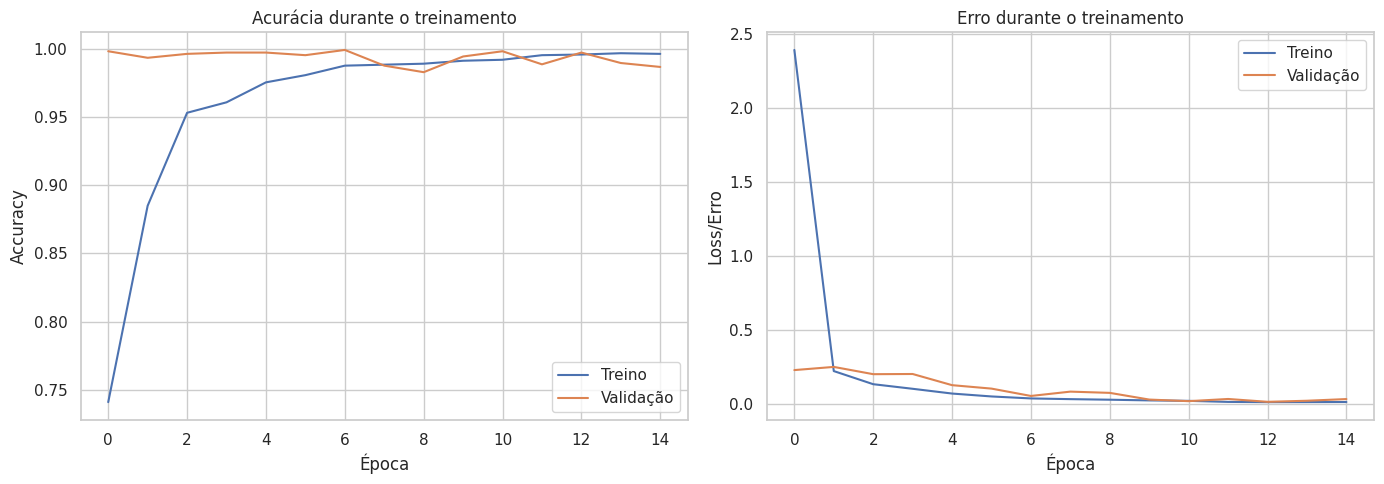

In [ ]:
# 📊 PLOTS DAS MÉTRICAS DE TREINAMENTO

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Cria dois subgráficos lado a lado em uma figura de tamanho 14x5

# 📈 Gráfico da acurácia por época
axes[0].plot(treinamento.history['accuracy'], label='Treino')           # Linha da acurácia no conjunto de treino
axes[0].plot(treinamento.history['val_accuracy'], label='Validação')    # Linha da acurácia no conjunto de validação
axes[0].set_title('Acurácia durante o treinamento')                     # Título do gráfico
axes[0].set_xlabel('Época')                                             # Rótulo do eixo X
axes[0].set_ylabel('Accuracy')                                          # Rótulo do eixo Y
axes[0].legend()                                                        # Exibe a legenda

# 📉 Gráfico da perda (erro) por época
axes[1].plot(treinamento.history['loss'], label='Treino')               # Linha da perda no conjunto de treino
axes[1].plot(treinamento.history['val_loss'], label='Validação')        # Linha da perda no conjunto de validação
axes[1].set_title('Erro durante o treinamento')                         # Título do gráfico
axes[1].set_xlabel('Época')                                             # Rótulo do eixo X
axes[1].set_ylabel('Loss/Erro')                                         # Rótulo do eixo Y
axes[1].legend()                                                        # Exibe a legenda

plt.tight_layout()  # Ajusta o espaçamento entre os subplots
plt.show()          # Exibe os gráficos


In [ ]:
# 🧪 FILTRAGEM DO CONJUNTO DE TESTE PARA CLASSIFICAÇÃO BINÁRIA

# Cria uma máscara para manter apenas as amostras com rótulo 0 ou 1
mask_teste_bin = y_teste <= 1

# Aplica a máscara para filtrar o conjunto de teste
X_teste_bin = X_teste[mask_teste_bin]      # Imagens com rótulos 0 ou 1
y_teste_bin = y_teste[mask_teste_bin]      # Rótulos correspondentes (0 = NORMAL, 1 = PNEUMONIA)


## 🧾 7. Avaliação no Conjunto de Teste

In [ ]:
# 🧾 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (BINÁRIO)

# Avalia o desempenho da rede no conjunto de teste filtrado (apenas classes 0 e 1)
resultado_teste = rede.evaluate(X_teste_bin, y_teste_bin)

# Exibe o resultado da avaliação: perda e acurácia
print(f"🧪 Resultado no teste: Loss = {resultado_teste[0]:.4f}, Accuracy = {resultado_teste[1]:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.3955 - loss: 2.4895
🧪 Resultado no teste: Loss = 1.3064, Accuracy = 0.6779


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


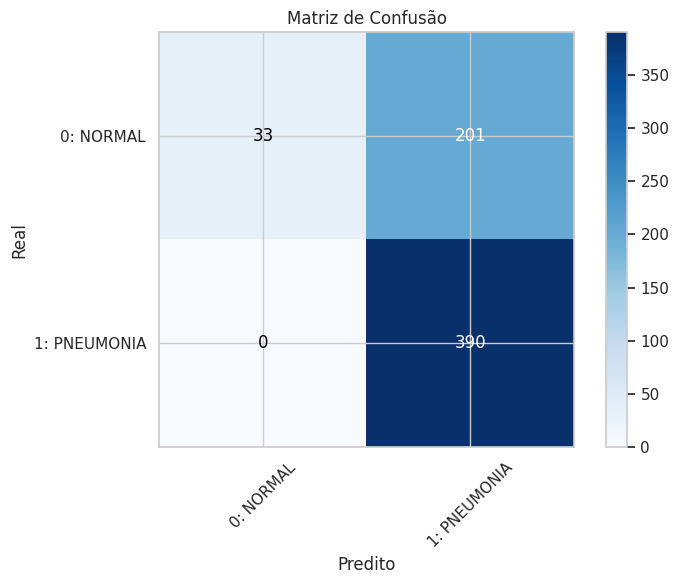

In [ ]:
# 🔍 MATRIZ DE CONFUSÃO PARA AVALIAÇÃO DETALHADA DAS PREDIÇÕES

from sklearn.metrics import confusion_matrix  # Importa função para gerar matriz de confusão

# ⚠️ Gera as predições da rede para o conjunto de teste completo
predicoes = rede.predict(X_teste)  # Saídas em formato de probabilidades (softmax)

# Converte as predições para rótulos inteiros (classe com maior probabilidade)
y_pred = np.argmax(predicoes, axis=1)

# 🧮 Gera a matriz de confusão comparando rótulos reais com predições
cm = confusion_matrix(y_teste, y_pred)

# 🎨 Plota a matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))                     # Cria figura com tamanho ajustado
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Mapeia os valores com tons de azul
ax.set_title('Matriz de Confusão')                         # Título do gráfico
fig.colorbar(im, ax=ax)                                    # Barra de cores ao lado do gráfico

# Define rótulos nos eixos
tick_marks = np.arange(len(nomes_classes))                # Posições dos ticks (0 e 1)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels([f"{i}: {nome}" for i, nome in enumerate(nomes_classes)], rotation=45)  # Legenda horizontal
ax.set_yticklabels([f"{i}: {nome}" for i, nome in enumerate(nomes_classes)])               # Legenda vertical
ax.set_ylabel('Real')                                     # Eixo Y = valores reais
ax.set_xlabel('Predito')                                  # Eixo X = valores previstos pelo modelo

# 🧾 Adiciona os valores numéricos nas células da matriz
thresh = cm.max() / 2  # Limite para cor do texto (branco ou preto)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()  # Ajusta espaçamento
plt.show()          # Exibe o gráfico


## 🔁 8. Validação Cruzada com K-Fold

In [ ]:
# 🔁 AVALIAÇÃO COM K-FOLD CROSS-VALIDATION (5 PARTIÇÕES ESTRATIFICADAS)

from sklearn.model_selection import StratifiedKFold  # Importa o validador KFold com estratificação

resultados = []  # Lista para armazenar os resultados de cada iteração

# 🧼 Filtra os dados para conter apenas classes 0 e 1 (NORMAL e PNEUMONIA)
mask_bin = y_treinamento <= 1
X_treinamento = X_treinamento[mask_bin]
y_treinamento = y_treinamento[mask_bin]

# 🔀 Cria um KFold estratificado com 5 divisões, embaralhando os dados
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🔂 Loop pelas divisões do KFold
for i_treino, i_teste in kfold.split(X_treinamento, y_treinamento):

    # 🔧 Cria uma nova instância do modelo para cada fold
    rede_cv = Sequential([
        InputLayer(input_shape=(128, 128, 1)),                            # Camada de entrada
        Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'),           # Camada convolucional
        BatchNormalization(),                                          # Normalização
        MaxPooling2D(pool_size=POOL_SIZE),                             # Pooling
        Flatten(),                                                     # Achata o mapa de ativação
        Dense(DENSE_UNITS, activation='relu'),                         # Camada densa intermediária
        Dropout(DROPOUT_RATE),                                         # Dropout para evitar overfitting
        Dense(len(nomes_classes), activation='softmax')                # Camada de saída com softmax
    ])

    # ⚠️ Aqui está o problema: você está usando `softmax` com 2 classes → mude para `sigmoid` e `binary_crossentropy`
    # (se nomes_classes = ['NORMAL', 'PNEUMONIA'], len(nomes_classes) = 2, mas o modelo está tratando como multiclasse)

    rede_cv.compile(
        loss='sparse_categorical_crossentropy',  # Usa função de perda para classificação com rótulos inteiros
        optimizer=OPTIMIZER,
        metrics=['accuracy']
    )

    # ▶️ Treina o modelo com os dados do fold atual
    rede_cv.fit(
        X_treinamento[i_treino], y_treinamento[i_treino],         # Dados de treino do fold
        batch_size=BATCH_SIZE,
        epochs=4,
        validation_split=VALIDATION_SPLIT,                         # Divide parte dos dados de treino para validação interna
        callbacks=[early_stopping]
    )

    # 📊 Avalia o modelo com os dados de teste do fold e salva o resultado
    resultados.append(rede_cv.evaluate(X_treinamento[i_teste], y_treinamento[i_teste]))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7188 - loss: 13.6518 - val_accuracy: 1.0000 - val_loss: 0.0518
Epoch 2/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9035 - loss: 0.2249 - val_accuracy: 0.9964 - val_loss: 0.1559
Epoch 3/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9446 - loss: 0.1349 - val_accuracy: 0.9892 - val_loss: 0.2053
Epoch 4/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9515 - loss: 0.1150 - val_accuracy: 0.9880 - val_loss: 0.2077
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.4181 - loss: 1.0697
Epoch 1/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6995 - loss: 10.9987 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 2/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9139 - loss: 0.6590 - val_accuracy: 0.9725 - val_loss: 0.4644
Epoch 3/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9645 - loss: 0.0953 - val_accuracy: 0.9904 - val_loss: 0.3510
Epoch 4/4
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 3

In [ ]:
# 📈 CÁLCULO DAS MÉTRICAS MÉDIAS E DESVIO PADRÃO DO K-FOLD

resultados = np.array(resultados)        # Converte a lista de resultados para um array NumPy (n_folds, 2)
losses = resultados[:, 0]                # Extrai as perdas (loss) de cada fold
accuracies = resultados[:, 1]            # Extrai as acurácias de cada fold

# 📊 Calcula a média e o desvio padrão da perda e da acurácia
media_loss, std_loss = np.mean(losses), np.std(losses)
media_acc, std_acc   = np.mean(accuracies), np.std(accuracies)

# 🖨️ Exibe os resultados finais com 4 casas decimais
print(f'📊 Média dos erros: {media_loss:.4f} ± {std_loss:.4f}')
print(f'📊 Média das acurácias: {media_acc:.4f} ± {std_acc:.4f}')


📊 Média dos erros: 0.5173 ± 0.2789
📊 Média das acurácias: 0.7838 ± 0.0720


# 🔬 9. Tuning de Hiperparâmetros (Grid Search) – A implementar

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

# 🔁 Parâmetros do Grid
param_grid = {
    'num_filters': [16, 32],
    'kernel_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# 🧠 Nome das classes (binárias)
num_classes = 2

# 📦 Divisão do conjunto de treino em treino e validação
X_train_gs, X_val_gs, y_train_gs, y_val_gs = train_test_split(
    X_treinamento_bin, y_treinamento_bin, test_size=0.2, stratify=y_treinamento_bin, random_state=42
)

# 📊 Armazenar resultados
resultados_grid = []

# 🔄 Loop por todas as combinações
for nf in param_grid['num_filters']:
    for ks in param_grid['kernel_size']:
        for dr in param_grid['dropout_rate']:
            for opt_name in param_grid['optimizer']:

                print(f"Treinando com filtros={nf}, kernel={ks}, dropout={dr}, optimizer={opt_name}")

                # Escolher otimizador
                if opt_name == 'adam':
                    opt = Adam()
                elif opt_name == 'rmsprop':
                    opt = RMSprop()

                # Modelo
                modelo = Sequential([
                    InputLayer(input_shape=(128, 128, 1)),
                    Conv2D(nf, ks, activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(dr),
                    Dense(num_classes, activation='softmax')
                ])

                modelo.compile(optimizer=opt,
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])

                hist = modelo.fit(
                    X_train_gs, y_train_gs,
                    validation_data=(X_val_gs, y_val_gs),
                    batch_size=128,
                    epochs=5,
                    verbose=0  # Silencia para ficar mais limpo
                )

                acc = hist.history['val_accuracy'][-1]
                loss = hist.history['val_loss'][-1]
                resultados_grid.append({
                    'filtros': nf,
                    'kernel': ks,
                    'dropout': dr,
                    'optimizer': opt_name,
                    'val_accuracy': acc,
                    'val_loss': loss
                })

# 📋 Mostrar os resultados em um DataFrame
df_grid = pd.DataFrame(resultados_grid)
df_grid = df_grid.sort_values(by='val_accuracy', ascending=False)
display(df_grid)

Treinando com filtros=16, kernel=(3, 3), dropout=0.2, optimizer=adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Treinando com filtros=16, kernel=(3, 3), dropout=0.2, optimizer=rmsprop
Treinando com filtros=16, kernel=(3, 3), dropout=0.5, optimizer=adam
Treinando com filtros=16, kernel=(3, 3), dropout=0.5, optimizer=rmsprop
Treinando com filtros=16, kernel=(5, 5), dropout=0.2, optimizer=adam
Treinando com filtros=16, kernel=(5, 5), dropout=0.2, optimizer=rmsprop
Treinando com filtros=16, kernel=(5, 5), dropout=0.5, optimizer=adam


KeyboardInterrupt: 

# 🧠 10. Arquitetura Clássica da Literatura – A implementar


# 📊 11. Comparação dos Resultados


# ✅ 12. Conclusão e Aprendizados
